In [1]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from dataset import DrumPatternDataset
from hierarchical_vae import HierarchicalDrumVAE
from analyze_latent import (
    visualize_latent_hierarchy, measure_disentanglement,
    interpolate_styles, controllable_generation,
    compute_style_means, sample_10_per_style, style_transfer_examples,
    interpret_latent_dimensions
)

In [4]:
data_dir = '../data/drums'
gen_dir  = 'results/generated_patterns'
ana_dir  = 'results/latent_analysis'
os.makedirs(gen_dir, exist_ok=True)
os.makedirs(ana_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
valset = DrumPatternDataset(data_dir, split='val')
val_loader = DataLoader(valset, batch_size=256, shuffle=False)
model = HierarchicalDrumVAE(z_high_dim=4, z_low_dim=12).to(device)
model.load_state_dict(torch.load('results/best_model.pth', map_location=device))
model.eval()

HierarchicalDrumVAE(
  (enc_conv): Sequential(
    (0): Conv1d(9, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU(inplace=True)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu_low): Linear(in_features=512, out_features=12, bias=True)
  (fc_logvar_low): Linear(in_features=512, out_features=12, bias=True)
  (enc_high): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU(inplace=True)
  )
  (fc_mu_high): Linear(in_features=32, out_features=4, bias=True)
  (fc_logvar_high): Linear(in_features=32, out_features=4, bias=True)
  (prior_low_mu): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_

[OK] t-SNE and latent metrics saved to: results/latent_analysis
[METRICS] {'z_high_overall_var': 0.3010159432888031, 'z_low_overall_var': 2.5046756267547607, 'z_high_within_var_mean': 0.229273721575737, 'z_low_within_var_mean': 1.3300776481628418, 'disentangle_score': 0.7616663471512601}


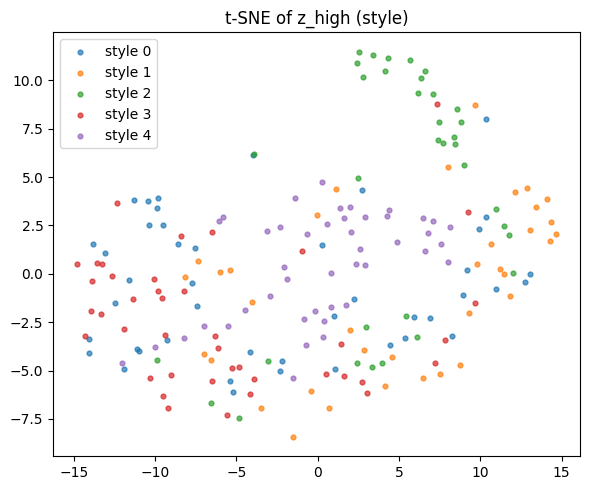

In [6]:
visualize_latent_hierarchy(model, val_loader, results_dir=ana_dir, device=device)
metrics = measure_disentanglement(model, val_loader, results_dir=ana_dir, device=device)
print('[OK] t-SNE and latent metrics saved to:', ana_dir)
print('[METRICS]', metrics)

[OK] Interpolation saved: results/generated_patterns/interpolation.npy
[OK] Interpolation density saved: results/generated_patterns/interpolation_density.png


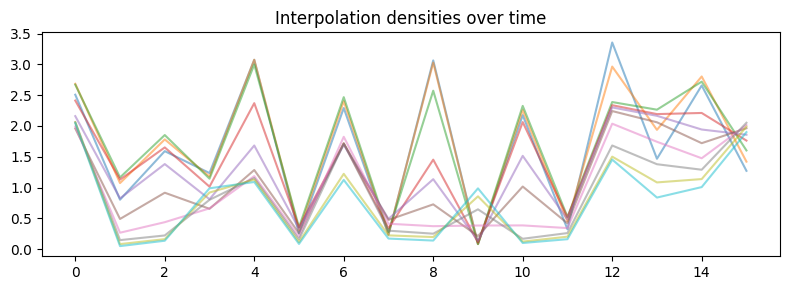

In [7]:
styles = np.array([valset[i][1] for i in range(len(valset))])
uniq = np.unique(styles)
if len(uniq) < 2:
    raise RuntimeError('验证集风格数不足 2，无法进行风格插值。')
idx_a = int(np.where(styles == uniq[0])[0][0])
idx_b = int(np.where(styles == uniq[1])[0][0])
interpolate_styles(model, valset[idx_a][0], valset[idx_b][0], n_steps=10, results_dir=gen_dir, device=device)
print('[OK] Interpolation saved:', os.path.join(gen_dir, 'interpolation.npy'))
print('[OK] Interpolation density saved:', os.path.join(gen_dir, 'interpolation_density.png'))

In [8]:
style_means = compute_style_means(model, val_loader, device=device)
sample_10_per_style(model, style_means, n_per_style=10, temperature=0.9, results_dir=gen_dir, device=device)
print('[OK] 10-per-style saved:', os.path.join(gen_dir, 'samples_10_per_style.npz'))

[OK] 10-per-style saved: results/generated_patterns/samples_10_per_style.npz


In [9]:
style_transfer_examples(model, val_loader, style_means, k_per_style=2, temperature=0.9, results_dir=gen_dir, device=device)
print('[OK] Style transfer saved:', os.path.join(gen_dir, 'style_transfer_examples.npz'))

[OK] Style transfer saved: results/generated_patterns/style_transfer_examples.npz


In [10]:
base_idx = int(np.where(styles == uniq[0])[0][0])
interpret_latent_dimensions(model, valset[base_idx][0], sweep_std=3.0, steps=7, which='both', results_dir=ana_dir, device=device)
print('[OK] Dimension interpretation saved:', os.path.join(ana_dir, 'dimension_interpretation.npz'))

[OK] Dimension interpretation saved: results/latent_analysis/dimension_interpretation.npz


In [11]:
controllable_generation(model, genre_labels=sorted(list(map(int, np.unique(styles)))), n_per_genre=10, temperature=0.9, results_dir=gen_dir, device=device)
print('[OK] Controllable generation saved:', os.path.join(gen_dir, 'controllable_generation.npy'))

[OK] Controllable generation saved: results/generated_patterns/controllable_generation.npy
